In [1]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

from itertools import chain
import collections

from nltk.corpus import stopwords

In [2]:
df_bbc = pd.read_csv('tweets_bbc.csv',low_memory=False)
df_cnn = pd.read_csv('tweets_cnn.csv',low_memory=False)
df_eco = pd.read_csv('tweets_eco.csv',low_memory=False)

In [3]:
df_tweets = pd.concat([df_bbc, df_cnn, df_eco])

In [4]:
df_tweets = df_tweets.reset_index(drop=True)

In [5]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [6]:
tweets_nu = pd.DataFrame([remove_url(str(tweet)) for tweet in df_tweets['tweet']], columns=['tweet'])

In [7]:
df_tweets['tweet_length'] = tweets_nu['tweet'].str.len()

In [8]:
tweet_words = [tweet.lower().split() for tweet in tweets_nu['tweet']]

In [9]:
all_words = list(chain(*tweet_words))
word_counts = collections.Counter(all_words)
word_counts.most_common(15)

[('the', 267049),
 ('of', 152760),
 ('to', 145119),
 ('in', 136203),
 ('a', 122122),
 ('and', 82509),
 ('is', 75749),
 ('for', 54004),
 ('on', 53605),
 ('are', 38503),
 ('from', 36262),
 ('has', 36020),
 ('that', 32220),
 ('it', 29693),
 ('as', 28818)]

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dheeraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in tweet_words]

In [13]:
all_words = list(chain(*tweets_nsw))
word_counts = collections.Counter(all_words)

df_mcw = pd.DataFrame(word_counts.most_common(15), columns=['words','count'])

In [14]:
tweet_hashtags = [str(hashtags).replace('[','').replace(']','').replace('\'','') for hashtags in df_tweets['hashtags'] if not '[]' in str(hashtags)]

In [15]:
hashtag_count = collections.Counter(tweet_hashtags)

df_mch = pd.DataFrame(hashtag_count.most_common(15), columns=['hashtags','count'])

In [16]:
df_tweets['total_metric_count'] = df_tweets[['replies_count', 'likes_count', 'retweets_count']].sum(axis=1)
df_max = df_tweets[df_tweets['total_metric_count'] == df_tweets['total_metric_count'].max()]
df_max['tweet']
# df_tweets.iloc[df_tweets['total_metric_count'].idxmax()]

36805    BREAKING: JOE BIDEN WINS  Joe Biden will be th...
Name: tweet, dtype: object

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((df_tweets['tweet'])) #fitting and transforming the vector
tfidf_jobid

<344196x489770 sparse matrix of type '<class 'numpy.float64'>'
	with 6360992 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
tweet_count = tfidf_vectorizer.transform(df_max['tweet'])
cos_similarity_countv = map(lambda x: cosine_similarity(tweet_count, x),tfidf_jobid)

In [20]:
def get_recommendation(top, df_all, scores):
    recommendation = pd.DataFrame(columns = ['id', 'tweet',  'replies_count', 'likes_count',  'retweets_count',  'score'])
    count = 0
    for i in top:
        recommendation.at[count, 'id'] = df_all['id'][i]
        recommendation.at[count, 'tweet'] = df_all['tweet'][i]
        recommendation.at[count, 'replies_count'] = df_all['replies_count'][i]
        recommendation.at[count, 'likes_count'] = df_all['likes_count'][i]
        recommendation.at[count, 'retweets_count'] = df_all['retweets_count'][i]
        recommendation.at[count, 'score'] =  scores[count]
        count += 1
    return recommendation

In [21]:
output2 = list(cos_similarity_countv)

In [22]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df_tweets, list_scores)

,id,tweet,replies_count,likes_count,retweets_count,score
0,1325112617669693440,BREAKING: JOE BIDEN WINS Joe Biden will be th...,4309,241132,77009,1.0
1,1325114035063435272,BREAKING: JOE BIDEN WINS Joe Biden will be th...,2205,73221,18731,0.803248
2,1351936049749118979,Joe Biden sworn in as the 46th president of th...,355,12275,1823,0.38807
3,1351936566466400258,"""Congratulations Mr President"" Joe Biden swor...",133,4938,1131,0.277133
4,1351935761864658945,Joe Biden has taken the oath of office. What w...,11,244,29,0.271743
5,1323807294333870086,CNN PROJECTION: Joe Biden wins New York https...,363,16278,1598,0.267061
6,1323851015918129152,CNN PROJECTION: Joe Biden wins Virginia https...,219,11752,899,0.266604
7,1323829942925381632,CNN PROJECTION: Joe Biden wins New Mexico htt...,82,4689,318,0.266403
8,1324148679108894723,Michigan has been called for Joe Biden. If Mr ...,82,3735,735,0.265783
9,1324109613701210117,Michigan has been called for Joe Biden. If Mr ...,127,5861,1270,0.265783


In [23]:
from sklearn.neighbors import NearestNeighbors
KNN = NearestNeighbors(n_neighbors=11,p=2)
KNN.fit(tfidf_jobid)
NNs = KNN.kneighbors(tweet_count, return_distance=True) 

In [24]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(top, df_tweets, index_score)

,id,tweet,replies_count,likes_count,retweets_count,score
0,1325114035063435272,BREAKING: JOE BIDEN WINS Joe Biden will be th...,2205,73221,18731,0.627299
1,1351936049749118979,Joe Biden sworn in as the 46th president of th...,355,12275,1823,1.106282
2,1351936566466400258,"""Congratulations Mr President"" Joe Biden swor...",133,4938,1131,1.202387
3,1351935761864658945,Joe Biden has taken the oath of office. What w...,11,244,29,1.206861
4,1323807294333870086,CNN PROJECTION: Joe Biden wins New York https...,363,16278,1598,1.210734
5,1323851015918129152,CNN PROJECTION: Joe Biden wins Virginia https...,219,11752,899,1.211112
6,1323829942925381632,CNN PROJECTION: Joe Biden wins New Mexico htt...,82,4689,318,1.211278
7,1324109613701210117,Michigan has been called for Joe Biden. If Mr ...,127,5861,1270,1.21179
8,1324148679108894723,Michigan has been called for Joe Biden. If Mr ...,82,3735,735,1.21179
9,1323814998947356672,CNN PROJECTION: Joe Biden wins Colorado https...,109,6830,444,1.212185


In [25]:
from wordcloud import ImageColorGenerator

In [26]:
df_cloud_mcw = pd.DataFrame(word_counts.most_common(1000), columns=['words','count'])

In [27]:
bunch_word = " ".join(text for text in df_cloud_mcw['words'])

In [28]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_word)

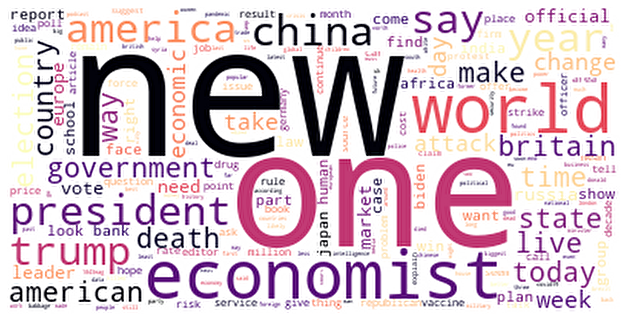

In [29]:
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [30]:
df_cloud_mch = pd.DataFrame(hashtag_count.most_common(1000), columns=['hashtags','count'])

In [31]:
bunch_hashtag = " ".join(text for text in df_cloud_mch['hashtags'])

In [32]:
hashcloud = WordCloud(stopwords=stopwords, background_color="white").generate(bunch_hashtag)

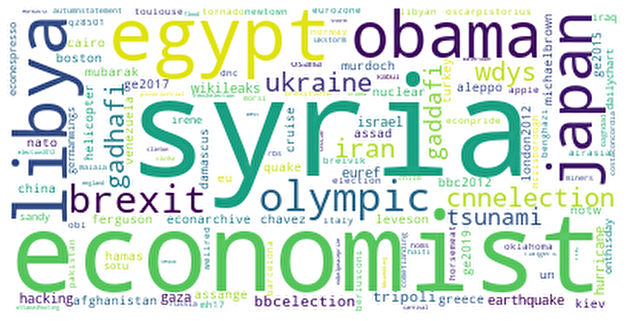

In [33]:
plt.figure(figsize=[11,11])
plt.imshow(hashcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [34]:
df_tweets['date_time'] = pd.to_datetime(df_tweets['date'] + ' ' + df_tweets['time'], errors='coerce')

In [35]:
df_tweets['year'] = df_tweets['date_time'].dt.year
df_tweets['month'] = df_tweets['date_time'].dt.month
df_tweets['day'] = df_tweets['date_time'].dt.day
df_tweets['dayofweek'] = df_tweets['date_time'].dt.dayofweek
df_tweets['hour'] = df_tweets['date_time'].dt.hour
df_tweets['minute'] = df_tweets['date_time'].dt.minute
df_tweets['dayofyear'] = df_tweets['date_time'].dt.dayofyear
df_tweets['date_only'] = df_tweets['date_time'].dt.date

In [36]:
df_tweets['hashtags']=df_tweets['hashtags'].replace({'[]':np.nan})

In [37]:
df_tweets.hashtags.value_counts()

['economist']                     1903
['openfuture']                    1899
['econarchive']                   1520
['onthisday']                     1251
['dailychart']                     821
                                  ... 
['stratocaster']                     1
['bobfilner']                        1
['washington', 'weather']            1
['timepersonoftheyear']              1
['economist', 'iran', 'cop15']       1
Name: hashtags, Length: 8473, dtype: int64

In [38]:
data = df_tweets.drop(['retweet_date', 'translate', 'trans_src','trans_dest', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'place', 'thumbnail', 'quote_url', 'id', 'conversation_id', 'link', 'urls', 'photos', 'user_id', 'cashtags'],
               axis =  1)

In [39]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    dataframe = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    dataframe['Types'] = types
    return(np.transpose(dataframe))

missing_data(data)

,created_at,date,time,timezone,username,name,tweet,language,mentions,replies_count,...,total_metric_count,date_time,year,month,day,dayofweek,hour,minute,dayofyear,date_only
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,object,object,int64,object,object,object,object,object,int64,...,int64,datetime64[ns],int64,int64,int64,int64,int64,int64,int64,object


In [40]:
def unique_values(data):
    total = data.count()
    dataframe = pd.DataFrame(total)
    dataframe.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    dataframe['Uniques'] = uniques
    return(np.transpose(dataframe))

unique_values(data)

,created_at,date,time,timezone,username,name,tweet,language,mentions,replies_count,...,total_metric_count,date_time,year,month,day,dayofweek,hour,minute,dayofyear,date_only
Total,344196,344196,344196,344196,344196,344196,344196,344196,344196,344196,...,344196,344196,344196,344196,344196,344196,344196,344196,344196,344196
Uniques,340340,4204,82757,1,3,3,343994,32,4147,1387,...,6609,340340,12,12,31,7,24,60,366,4204


In [41]:
def most_frequent_values(data):
    total = data.count()
    dataframe = pd.DataFrame(total)
    dataframe.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    dataframe['Most frequent values'] = items
    dataframe['Frequency'] = vals
    dataframe['Percent from total'] = np.round(vals / total * 100, 2)
    return(np.transpose(dataframe))

most_frequent_values(data)

,created_at,date,time,timezone,username,name,tweet,language,mentions,replies_count,...,total_metric_count,date_time,year,month,day,dayofweek,hour,minute,dayofyear,date_only
Total,344196,344196,344196,344196,344196,344196,344196,344196,344196,344196,...,344196,344196,344196,344196,344196,344196,344196,344196,344196,344196
Most frequent values,2018-12-13 22:17:06 IST,2015-05-08,01:30:06,530,theeconomist,The Economist,The Economist Editor's Highlights: View select...,en,[],3,...,58,2018-12-13 22:17:06,2020,5,18,4,22,30,128,2015-05-08
Frequency,10,296,140,344196,254413,254413,24,342318,315503,25617,...,1831,10,48940,32602,11642,54038,18161,19442,1274,296
Percent from total,0.0,0.09,0.04,100.0,73.92,73.92,0.01,99.45,91.66,7.44,...,0.53,0.0,14.22,9.47,3.38,15.7,5.28,5.65,0.37,0.09


/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


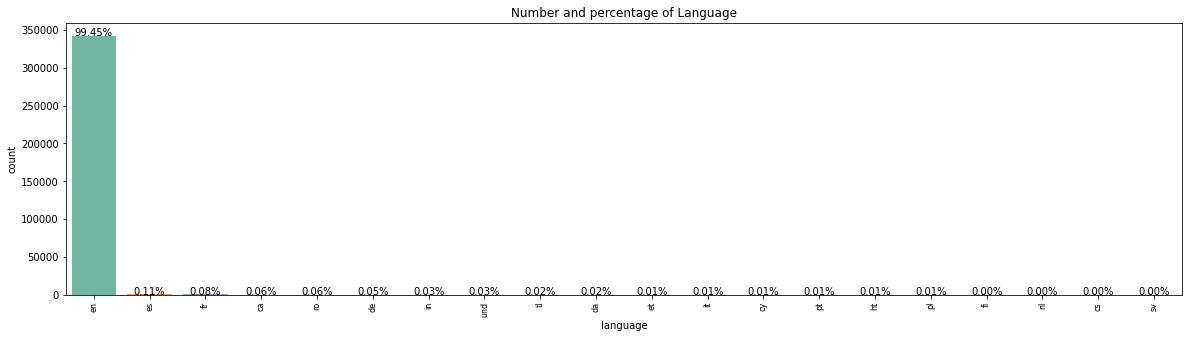

In [42]:
import seaborn as sns

def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(5*size,5))
    total = float(len(data))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
    else:
        g = sns.countplot(df[feature], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  
    
plot_count("language", "Language", data,4)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


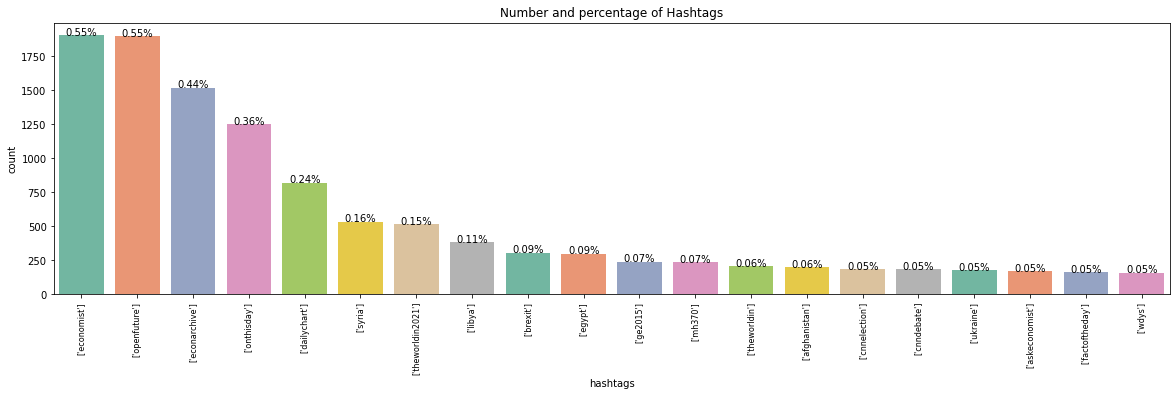

In [43]:
plot_count("hashtags", "Hashtags", data,4)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


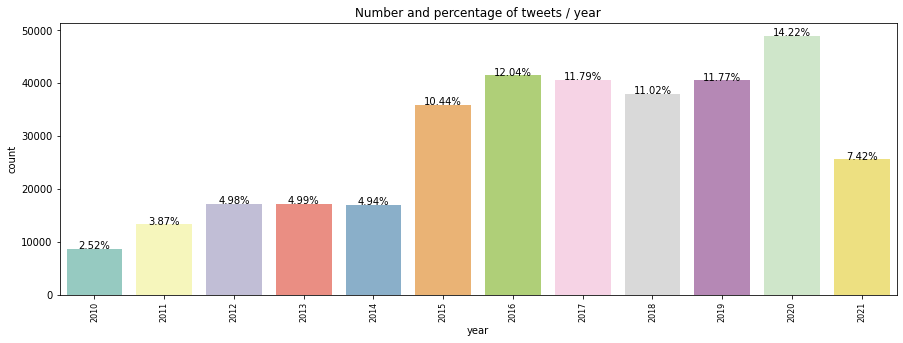

In [44]:
plot_count("year", "tweets / year", data, size=3, ordered=False)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


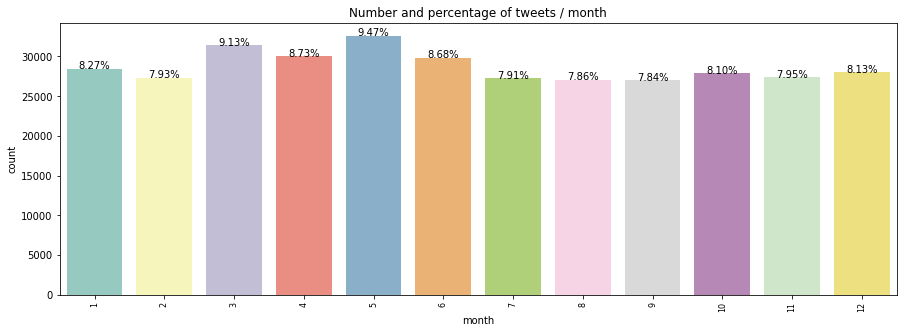

In [45]:
plot_count("month", "tweets / month", data, size=3, ordered=False)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


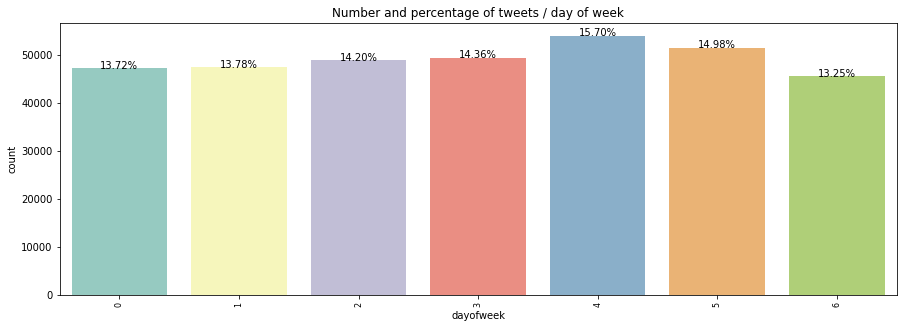

In [46]:
plot_count("dayofweek", "tweets / day of week", data, size=3, ordered=False)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


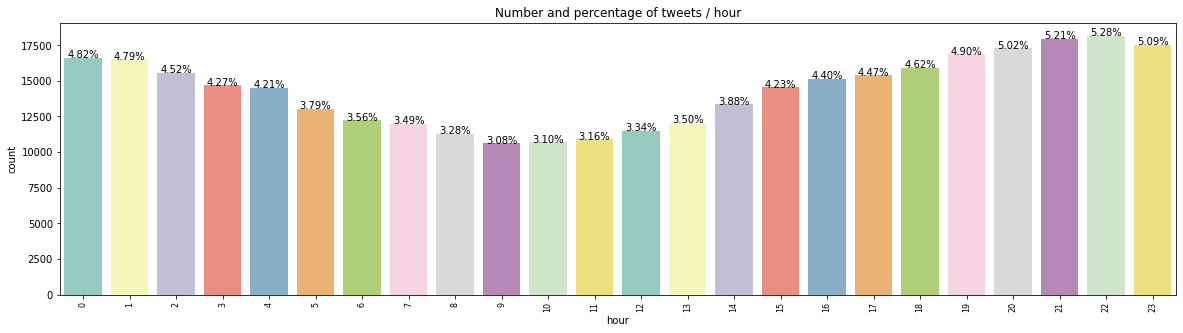

In [47]:
plot_count("hour", "tweets / hour", data,size=4, ordered=False)

/home/dheeraj/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


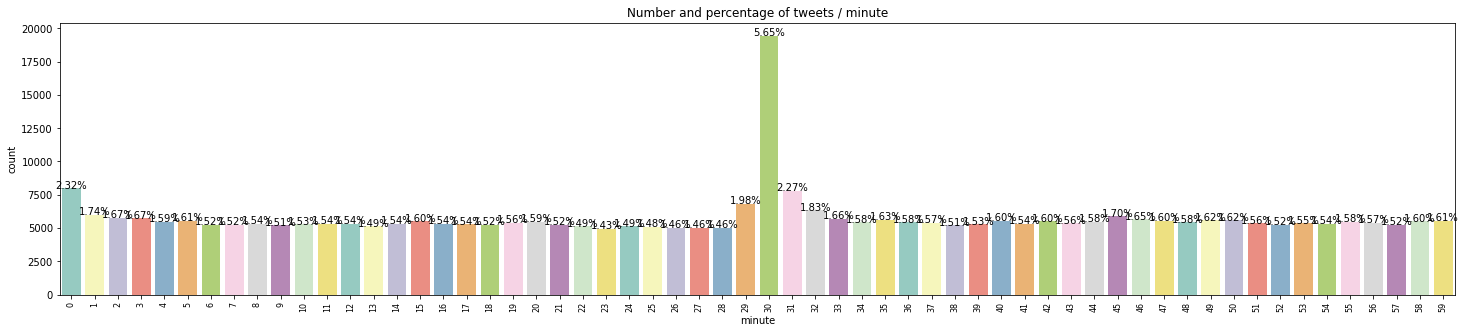

In [48]:
plot_count("minute", "tweets / minute", data,size=5, ordered=False)